In [1]:
!pip install torch faiss-cpu faiss-gpu-cu12 tqdm numpy==1.26.4

!pip install pyarrow==14.0.1 datasets==2.14.6 transformers==4.35.2 accelerate==0.24.1

In [2]:
import torch
import logging
import string
import re
import json
import time
import matplotlib.pyplot as plt
from transformers import (
    RagTokenizer,
    RagRetriever,
    RagSequenceForGeneration,
    RagTokenForGeneration
)
from datasets import load_dataset
from tqdm import tqdm

# ==========================================
# 1. SETUP & HELPER FUNCTIONS
# ==========================================

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")
logging.getLogger("transformers").setLevel(logging.ERROR)

/opt/micromamba/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/micromamba/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Running on: cuda


/opt/micromamba/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def calculate_em(predictions, references):
    total_em = 0
    for pred, refs in zip(predictions, references):
        if any(exact_match_score(pred, gt) for gt in refs):
            total_em += 1
    return 100 * (total_em / len(predictions))

In [4]:
class LocalRAGModelManager:
    def __init__(
        self,
        model_name,
        rag_type,        
        n_docs=5,
        index_name="exact",
    ):
        print(f"Initializing RAG Manager...")
        self.tokenizer = RagTokenizer.from_pretrained(model_name)
        self.retriever = RagRetriever.from_pretrained(model_name, index_name=index_name, use_dummy_dataset=False)

        print(f"[DEBUG] Loading Model from {model_name}...")
        ModelClass = RagTokenForGeneration if rag_type == "token" else RagSequenceForGeneration
        self.model = ModelClass.from_pretrained(model_name, retriever=self.retriever).to(device)

        self.model.config.n_docs = n_docs
        self.model.eval()
        print("[DEBUG] Model loaded successfully!")

    def set_n_docs(self, n_docs: int):
        self.n_docs = n_docs
        self.model.config.n_docs = n_docs
        if hasattr(self.retriever, "n_docs"):
            self.retriever.n_docs = n_docs
        if hasattr(self.retriever, "config"):
            self.retriever.config.n_docs = n_docs

    def generate_answers(self, questions, batch_size=4):
        all_answers = []
        for i in tqdm(range(0, len(questions), batch_size), desc=f"Generating (k={self.n_docs})"):
            batch_questions = questions[i: i + batch_size]
            inputs = self.tokenizer(
                batch_questions,
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(device)

            with torch.no_grad():
                generated_ids = self.model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    n_docs=self.model.config.n_docs,
                    num_beams=1,
                    max_new_tokens=16,
                    early_stopping=True
                )
            all_answers.extend(self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
        return all_answers

In [5]:
PATH_TO_TOKEN_CHECKPOINT = "WQ_models/facebook_rag-token-nq__token__wq_ft__nDocs10__20260117_163413" 
PATH_TO_SEQUENCE_CHECKPOINT = "WQ_models/facebook_rag-sequence-nq__sequence__wq_ft__nDocs10__20260118_124326"

K_VALUES = [3, 5, 7, 10, 20, 30]
NUM_SAMPLES = None
BATCH_SIZE = 8

# Load data
print("Loading WebQuestions Test Set...")
dataset = load_dataset("stanfordnlp/web_questions", split="test")

questions = [row['question'] for row in dataset]
answers = [row['answers'] for row in dataset]

print(f"Loaded {len(questions)} test samples from WebQuestions.")

Loading WebQuestions Test Set...
Loaded 2032 test samples from WebQuestions.


In [6]:
results = {
    "rag-token": {"scores": [], "k": K_VALUES},
    "rag-sequence": {"scores": [], "k": K_VALUES}
}

# Evaluate Fine-Tuned RAG-TOKEN
if PATH_TO_TOKEN_CHECKPOINT:
    print(f"\n=== Evaluating Fine-Tuned RAG-Token ===")
    rag_token_mgr = LocalRAGModelManager(
        model_name=PATH_TO_TOKEN_CHECKPOINT,
        rag_type="token"
    )

    for k in K_VALUES:
        print(f"\nProcessing k={k} for RAG-Token...")
        rag_token_mgr.set_n_docs(k)
        
        start_time = time.time()
        predictions = rag_token_mgr.generate_answers(questions, batch_size=BATCH_SIZE)
        score = calculate_em(predictions, answers)
        
        results["rag-token"]["scores"].append(score)
        with open("benchmark_wq_k_results.json", "w") as f:
            json.dump(results, f)
        print(f"WQ Score (k={k}): {score:.2f}% (Time: {time.time()-start_time:.1f}s)")

    # Clean up GPU memory
    del rag_token_mgr
    torch.cuda.empty_cache()
else:
    print("Skipping Token Model (No path provided)")


=== Evaluating Fine-Tuned RAG-Token ===
Initializing RAG Manager...


Using the latest cached version of the module from /home/jovyan/.cache/huggingface/modules/datasets_modules/datasets/wiki_dpr/66fd9b80f51375c02cd9010050e781ed3e8f759e868f690c31b2686a7a0eeb5c (last modified on Thu Jan 15 21:07:41 2026) since it couldn't be found locally at wiki_dpr., or remotely on the Hugging Face Hub.
/opt/micromamba/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the latest cached version of the module from /home/jovyan/.cache/huggingface/modules/datasets_modules/datasets/wiki_dpr/66fd9b80f51375c02cd9010050e781ed3e8f759e868f690c31b2686a7a0eeb5c (last modified on Thu Jan 15 21:07:41 2026) since it couldn't be found locally at wiki_dpr., or remotely on the Hugging Face Hub.


[DEBUG] Loading Model from WQ_models/facebook_rag-token-nq__token__wq_ft__nDocs10__20260117_163413...


/opt/micromamba/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


[DEBUG] Model loaded successfully!

Processing k=3 for RAG-Token...


Generating (k=3):   0%|          | 0/254 [00:00<?, ?it/s]/opt/micromamba/lib/python3.11/site-packages/transformers/generation/utils.py:2465: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=max_length)])` instead.
  warnings.warn(
Generating (k=3): 100%|██████████| 254/254 [07:00<00:00,  1.65s/it]


WQ Score (k=3): 31.74% (Time: 420.1s)

Processing k=5 for RAG-Token...


Generating (k=5): 100%|██████████| 254/254 [12:34<00:00,  2.97s/it]


WQ Score (k=5): 32.04% (Time: 754.9s)

Processing k=7 for RAG-Token...


Generating (k=7): 100%|██████████| 254/254 [17:28<00:00,  4.13s/it]


WQ Score (k=7): 32.53% (Time: 1048.2s)

Processing k=10 for RAG-Token...


Generating (k=10): 100%|██████████| 254/254 [22:11<00:00,  5.24s/it]


WQ Score (k=10): 32.63% (Time: 1331.8s)

Processing k=20 for RAG-Token...


Generating (k=20): 100%|██████████| 254/254 [43:37<00:00, 10.30s/it]


WQ Score (k=20): 32.68% (Time: 2617.2s)

Processing k=30 for RAG-Token...


Generating (k=30): 100%|██████████| 254/254 [1:06:02<00:00, 15.60s/it]


WQ Score (k=30): 32.82% (Time: 3962.7s)


In [7]:
# Evaluate Fine-Tuned RAG-SEQUENCE
if PATH_TO_SEQUENCE_CHECKPOINT:
    print(f"\n=== Evaluating Fine-Tuned RAG-Sequence ===")
    rag_seq_mgr = LocalRAGModelManager(
        model_name=PATH_TO_SEQUENCE_CHECKPOINT,
        rag_type="sequence"
    )

    for k in K_VALUES:
        print(f"\nProcessing k={k} for RAG-Sequence...")
        rag_seq_mgr.set_n_docs(k)

        start_time = time.time()
        predictions = rag_seq_mgr.generate_answers(questions, batch_size=BATCH_SIZE)
        score = calculate_em(predictions, answers)

        results["rag-sequence"]["scores"].append(score)
        with open("benchmark_wq_k_results.json", "w") as f:
            json.dump(results, f)
        print(f"WQ Score (k={k}): {score:.2f}% (Time: {time.time()-start_time:.1f}s)")

    del rag_seq_mgr
    torch.cuda.empty_cache()
else:
    print("Skipping Sequence Model (No path provided)")


=== Evaluating Fine-Tuned RAG-Sequence ===
Initializing RAG Manager...


Using the latest cached version of the module from /home/jovyan/.cache/huggingface/modules/datasets_modules/datasets/wiki_dpr/66fd9b80f51375c02cd9010050e781ed3e8f759e868f690c31b2686a7a0eeb5c (last modified on Thu Jan 15 21:07:41 2026) since it couldn't be found locally at wiki_dpr., or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/jovyan/.cache/huggingface/modules/datasets_modules/datasets/wiki_dpr/66fd9b80f51375c02cd9010050e781ed3e8f759e868f690c31b2686a7a0eeb5c (last modified on Thu Jan 15 21:07:41 2026) since it couldn't be found locally at wiki_dpr., or remotely on the Hugging Face Hub.


[DEBUG] Loading Model from WQ_models/facebook_rag-sequence-nq__sequence__wq_ft__nDocs10__20260118_124326...
[DEBUG] Model loaded successfully!

Processing k=3 for RAG-Sequence...


Generating (k=3):   0%|          | 0/254 [00:00<?, ?it/s]/opt/micromamba/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Generating (k=3): 100%|██████████| 254/254 [14:21<00:00,  3.39s/it]


WQ Score (k=3): 33.56% (Time: 861.7s)

Processing k=5 for RAG-Sequence...


Generating (k=5): 100%|██████████| 254/254 [27:44<00:00,  6.55s/it]


WQ Score (k=5): 35.09% (Time: 1664.4s)

Processing k=7 for RAG-Sequence...


Generating (k=7): 100%|██████████| 254/254 [45:03<00:00, 10.64s/it]


WQ Score (k=7): 36.37% (Time: 2703.7s)

Processing k=10 for RAG-Sequence...


Generating (k=10): 100%|██████████| 254/254 [1:15:39<00:00, 17.87s/it]


WQ Score (k=10): 37.01% (Time: 4539.3s)

Processing k=20 for RAG-Sequence...


Generating (k=20): 100%|██████████| 254/254 [3:34:10<00:00, 50.59s/it]  


WQ Score (k=20): 37.45% (Time: 12850.4s)

Processing k=30 for RAG-Sequence...


Generating (k=30):   0%|          | 0/254 [00:36<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.54 GiB. GPU 0 has a total capacity of 14.57 GiB of which 3.14 GiB is free. Process 2578282 has 11.43 GiB memory in use. Of the allocated memory 7.45 GiB is allocated by PyTorch, and 3.85 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

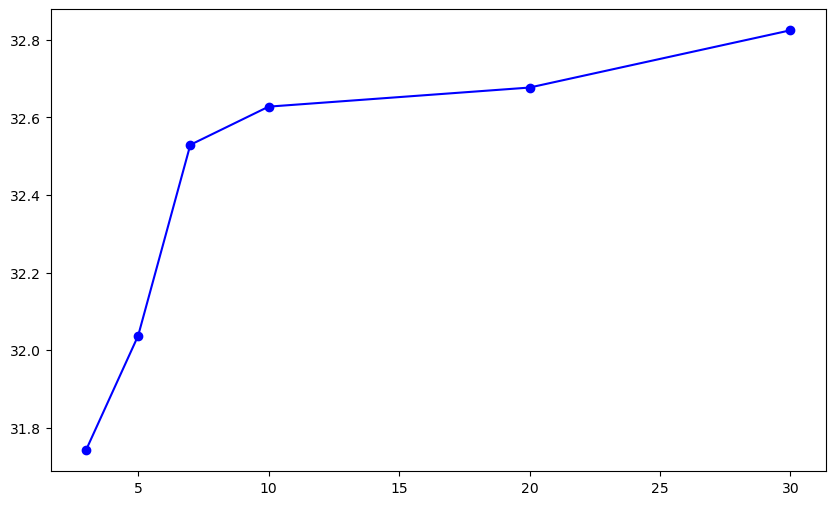

In [8]:
plt.figure(figsize=(10, 6))

# Plot RAG-Token (falls Ergebnisse da sind)
if results["rag-token"]["scores"]:
    plt.plot(
        results["rag-token"]["k"], 
        results["rag-token"]["scores"], 
        marker='o', 
        label='Fine-Tuned RAG-Token', 
        linestyle='-', 
        color='blue'
    )

# Plot RAG-Sequence (falls Ergebnisse da sind)
if results["rag-sequence"]["scores"]:
    plt.plot(
        results["rag-sequence"]["k"], 
        results["rag-sequence"]["scores"], 
        marker='s', 
        label='Fine-Tuned RAG-Sequence', 
        linestyle='--', 
        color='green'
    )

plt.title(f'RAG Performance on WebQuestions (Fine-Tuned) vs Retrieved Docs (k)\n(Samples: {len(questions)})')
plt.xlabel('Number of Retrieved Documents (k)')
plt.ylabel('Exact Match (EM) Score %')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(K_VALUES)

plt.savefig("wq_k_performance_finetuned.png")
print("Plot saved as 'wq_k_performance_finetuned.png'")
plt.show()